# Introduction
 In the following notebook, I aim to create a model of spiking neural network with conductance dynamics. The dynamics of each neuron can be seperated into membrane dynamics, synpase dynamics and spiking dynamics. In its simplest form the following equations goven the dynamics of each neuron 

### membrane dynamics 
membrane dynamics of neuron $i$ during integration has the following dynamics 
$$ C_m \frac{dV_i}{dt}= -I^{int}_i(t) - I^{syn}_i$$ 

the dynamics of the $I^{syn}_i$ can be described as follows
$$I^{syn}_i=\sum_j W_{ij} S_{ij}(t)[V_i(t)-E_{ij}]$$

### Firing dynamics
The firing dynamics of the neuron is model as a simple reseting. More specifically, 
$$V_i \rightarrow V_{reset} \ \ \  if \ \ \ V_i>=V_{\Theta} $$

$ V_{\Theta}$ represent the threshold voltage and $V_{reset}$ is the reset voltage of the neuron.

### Input dynamics 
Input synapes are the the site of learning in the spiking network. Below a conductance based formulation is presented. 
First, the time-dependent input conductance to membrane is calculated as follows 
$$ g_i(t) = \sum_j W_{ij} S_{ij}(t) $$

the term $j$ reperesent all the neurons that have a synapse onto the neuron $i$. the time dependence of conductance is due to $S(t)$ which represent the spiking activity for neurons connected to neuron $i$ . The spiking activity has the following governing equations 
$$ S_{ij} \rightarrow S_{ij}+1 \quad if \ neuron\ j\ fires$$
$$ \frac{dS_{ij}(t)}{dt} = \frac{-S_{ij}(t)}{\tau_s}$$ 

So each spike add a unit to $S_{ij}$ and the input decays with time constant $\tau_s$

# Implementation in TensorFlow

Given the dynamics presented about, neurons can be defined as object with the following functions:  
1. function for calucating the membrane dynamics.
2. function for calculating the firing event.
3. function for calculating the conductance. 

We implement the object in within tensorflow and define input as placeholders, and functions stated above are operations in a graph defined over TF variables that represent neurons.

the following parameters are defined as global (based on Fiete et. al. 2006)
$$ tau_m=3.0 \quad V_L=-60 \quad V_E= 0 \quad V_I= -70 \quad g_L=0.03 $$
$$V_{\Theta}=-50 \quad V_{reset}=-55 \quad \tau_s = 5 $$

in the implementation of the code lower case represent scalars and upper case represent vectors and matrices  

In [ ]:
from __future__ import print_function
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

In [ ]:
# basic LIFneuron 
class LIFNeuronSimple(object):
    # initialize the network object
    def __init__(self,n_Neur=1, tau_m=5.0, v_Theta=1, v_Reset=0.0, tau_s=5,spike_threshold=1.0,tau_refract=1.0):
        # number of neurons 
        self.n_Neur=n_Neur 
        # membrane capacitance  
        self.tau_m=tau_m
        # spike threshold potential
        self.v_Theta=v_Theta
        # Reset potential
        self.v_Reset=v_Reset
        # synapse time constant 
        self.tau_s=tau_s
        self.spike_threshold=spike_threshold
        #
        self.tau_refract=tau_refract
        # instantiate a graph for neuron 
        self.graph=tf.Graph()
        #build the graph 
        with self.graph.as_default():            
            # get vars and place holders for the network 
            self.get_vars_and_ph()
            # operations on the graph to implement the dynamics 
            self.potential, self.has_fired= self.get_response()
            # TODO : define outputs 

    # function for variables and placeholders 
    def get_vars_and_ph(self):
        self.V=tf.Variable(tf.constant(0.001,shape=[self.n_Neur,1],dtype=tf.float32),name='V')
        self.has_fired=tf.Variable(tf.constant(self.v_Reset,shape=[self.n_Neur,1],dtype=tf.float32),name='has_fired')
        self.V_Theta=tf.Variable(tf.constant(self.v_Theta,shape=[self.n_Neur,1],dtype=tf.float32),name='V_Theta')
        self.V_Reset=tf.constant(self.v_Reset,shape=[self.n_Neur,1],dtype=tf.float32,name='V_Reset')
        self.I_ext=tf.placeholder(dtype=tf.float32,shape=[self.n_Neur,1],name='I_ext')
        self.dt=tf.placeholder(dtype=tf.float32, name='dt')
        self.W=tf.Variable(tf.random.normal(shape=[self.n_Neur,self.n_Neur],mean=0.0,stddev=0.1,dtype=tf.float32),name='W')
        self.G=tf.Variable(tf.ones(shape=[self.n_Neur,1],dtype=tf.float32),name='G')
        self.S=tf.Variable(tf.zeros(shape=[self.n_Neur,self.n_Neur],dtype=tf.float32),name='S')
        self.I_syn=tf.Variable(tf.ones(shape=[self.n_Neur,1],dtype=tf.float32),name='I_syn')
        self.Tau_refractory=tf.constant(self.tau_refract,shape=[self.n_Neur,1],dtype=tf.float32,name='T_refractory')
        self.T_Reset=tf.Variable(tf.constant(0.0,shape=[self.n_Neur,1],dtype=tf.float32),name='T_refractory')
    # neuron dynamics during firing 
    def get_reset_op(self):
        has_fired_op=tf.greater_equal(self.V, self.V_Theta)
        v_update=tf.where(has_fired_op,self.V_Reset,self.V)
        return v_update, has_fired_op
    
    # update conductance 
    def get_conductance_op(self,has_fired_op,v_op,I_ext):
        dS_op=tf.divide(tf.negative(self.S),self.tau_s)
        S_op=tf.assign_add(self.S,dS_op*self.dt)
        has_fired_op_float=tf.dtypes.cast(has_fired_op,tf.float32)
        has_fired_ax=tf.tile(has_fired_op_float,[1,self.n_Neur])
        tf.assign_add(self.S,has_fired_ax)
        G_op=tf.assign(self.G,tf.reduce_sum(tf.multiply(self.W,self.S), 1, keepdims=True))
        I_syn=tf.assign(self.I_syn,tf.add(tf.multiply(G_op,v_op),I_ext))
        return G_op, S_op, I_syn

    # function for getting input Current 
    def get_input_op(self,has_fired_op,v_op):
        return tf.add(self.I_ext,0.0)
    
    # function for neuron dynamics during integration 
    def get_integrating_op(self,v_update,has_fired_op,G_op,S_op,I_syn):
        # update membrane potential
        t_subtract= tf.assign(self.T_Reset,tf.subtract(self.T_Reset,tf.constant(1.0,shape=[self.n_Neur,1])))
        t_margin=tf.assign(self.T_Reset,tf.where(tf.less(t_subtract,0.0),
                                        tf.constant(0.0,shape=[self.n_Neur,1]),
                                       t_subtract))
        t_reset_update=tf.assign(self.T_Reset,tf.where(has_fired_op,self.Tau_refractory,t_margin))
        eligilible_update=tf.equal(t_reset_update,tf.constant(0.0,shape=[self.n_Neur,1]))
        dV_op=tf.where(eligilible_update,tf.divide(
           tf.subtract(I_syn,v_update),self.tau_m),self.V_Reset)
        V_op=tf.assign(self.V,tf.minimum(tf.constant(self.spike_threshold,shape=[self.n_Neur,1]),
                                        tf.add(v_update,tf.multiply(dV_op,self.dt))))
        
    
        return V_op, has_fired_op
          
    def get_response(self):
        v_update,has_fired_op=self.get_reset_op()
        I_app=self.get_input_op(has_fired_op,v_update)
        G_op, S_op,I_syn=self.get_conductance_op(has_fired_op,v_update,I_app)
        V_op, has_fired_op=self.get_integrating_op(v_update,has_fired_op,G_op,S_op,I_syn)
        return V_op, has_fired_op
        
#################################
#################################



next we simulate 1 neuron to test the functionality 

In [ ]:
# testing 2 neurons 
# Duration of the simulation in ms
T = 200
# Duration of each time step in ms
dt = 1
# Number of iterations = T/dt
steps = int(T / dt)
# Output variables
I = []
U = []
V=[]

n_Neur=100
neuron = LIFNeuronSimple(n_Neur=n_Neur,tau_refract=5.0)

with tf.Session(graph=neuron.graph) as sess:

    sess.run(tf.global_variables_initializer())    

    for step in range(steps):
        
        t = step * dt
        # Set input current in mA
        if t > 5 and t < 50:
            I_ext = np.random.normal(1.5,1.5,[n_Neur,1])
        elif t > 4 and t < 100:
            I_ext = np.random.normal(1.5,1.5,[n_Neur,1])
        elif t > 120 and t < 180:
            I_ext = np.random.normal(1.5,1.5,[n_Neur,1])
        else:
            I_ext = np.random.normal(1.5,1.5,[n_Neur,1])
        feed = { neuron.I_ext: I_ext, neuron.dt: dt}
        
        #u, v = sess.run([neuron.potential, neuron.V_Update], feed_dict=feed)
        u,v = sess.run([neuron.potential,neuron.has_fired], feed_dict=feed)

        I.append(I_ext.flatten())
        U.append(u.flatten())
        V.append(v.flatten())

U1=np.array(U)
U2=np.array(V)

I_ext=np.expand_dims(I_ext,axis=0)
plt.rcParams["figure.figsize"] =(12,6)
# Draw the input current ahas_fired_op_floatnd the membrane potential
plt.figure()
plt.plot([i for i in I])
plt.title('Square input stimuli')
plt.ylabel('Input current (I)')
plt.xlabel('Time (msec)')
plt.xlim([0,T])
plt.figure()
plt.plot([u for u in U1])
a=plt.get_cmap()
#plt.axhline(y=1.0, color='r', linestyle='-')
plt.title('LIF response')
plt.ylabel('Membrane Potential (mV)')
plt.xlabel('Time (msec)')
plt.xlim([0,T])
# make a spike raster 
V1=np.asarray(V)
#V1=np.squeeze(V1,axis=2)
np.argwhere(V1==True)
steps,neurons=np.argwhere(V1==True).T

colors = cm.rainbow(np.linspace(0, 1, (n_Neur)))
plt.figure()
plt.scatter(steps*dt, neurons, s=3)
plt.xlim([0,T])

next step is combining a recurrent input with input to the network, testing synaptic input 

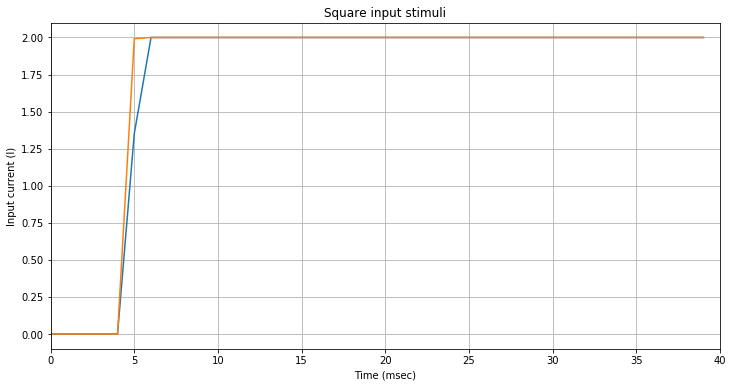

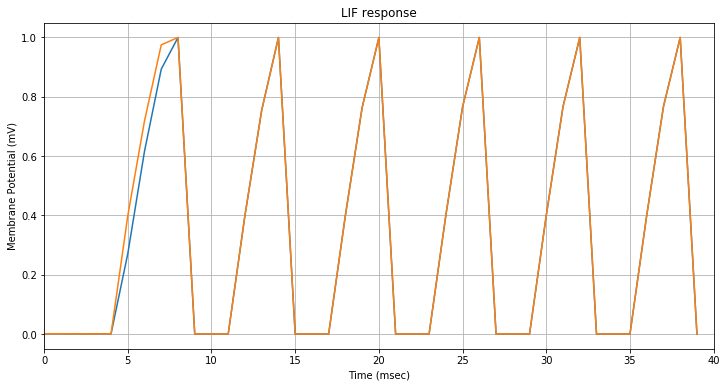

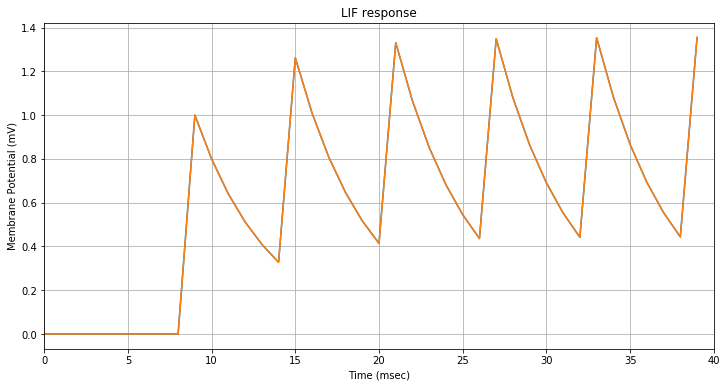

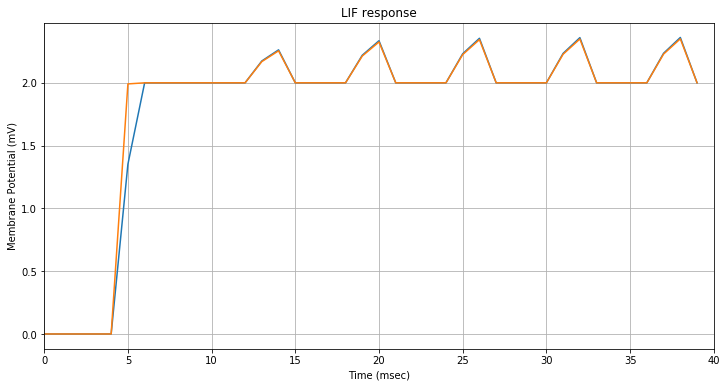

In [15]:
# basic LIFneuron 
class LIFNeuron(object):
    # initialize the network object
    def __init__(self,n_Neur=1, tau_m=5.0, v_Theta=1, v_Reset=0.0, tau_s=5,spike_threshold=1.0,tau_refract=1.0):
        # number of neurons 
        self.n_Neur=n_Neur 
        # membrane capacitance  
        self.tau_m=tau_m
        # spike threshold potential
        self.v_Theta=v_Theta
        # Reset potential
        self.v_Reset=v_Reset
        # synapse time constant 
        self.tau_s=tau_s
        self.spike_threshold=spike_threshold
        #
        self.tau_refract=tau_refract
        # instantiate a graph for neuron 
        self.graph=tf.Graph()
        #build the graph 
        with self.graph.as_default():            
            # get vars and place holders for the network 
            self.get_vars_and_ph()
            # operations on the graph to implement the dynamics 
            self.potential, self.has_fired, self.synapse_voltage, self.synapse_current= self.get_response()
            # TODO : define outputs 

    # function for variables and placeholders 
    def get_vars_and_ph(self):
        self.V=tf.Variable(tf.constant(0.001,shape=[self.n_Neur,1],dtype=tf.float32),name='V')
        self.has_fired=tf.Variable(tf.constant(self.v_Reset,shape=[self.n_Neur,1],dtype=tf.float32),name='has_fired')
        self.V_Theta=tf.Variable(tf.constant(self.v_Theta,shape=[self.n_Neur,1],dtype=tf.float32),name='V_Theta')
        self.V_Reset=tf.constant(self.v_Reset,shape=[self.n_Neur,1],dtype=tf.float32,name='V_Reset')
        self.I_ext=tf.placeholder(dtype=tf.float32,shape=[self.n_Neur,1],name='I_ext')
        self.dt=tf.placeholder(dtype=tf.float32, name='dt')
        self.W=tf.Variable(tf.random.normal(shape=[self.n_Neur,self.n_Neur],mean=1.0,stddev=0.1,dtype=tf.float32),name='W')
        self.G=tf.Variable(tf.ones(shape=[self.n_Neur,1],dtype=tf.float32),name='G')
        self.S=tf.Variable(tf.zeros(shape=[self.n_Neur,self.n_Neur],dtype=tf.float32),name='S')
        self.I_syn=tf.Variable(tf.ones(shape=[self.n_Neur,1],dtype=tf.float32),name='I_syn')
        self.Tau_refractory=tf.constant(self.tau_refract,shape=[self.n_Neur,1],dtype=tf.float32,name='T_refractory')
        self.T_Reset=tf.Variable(tf.constant(0.0,shape=[self.n_Neur,1],dtype=tf.float32),name='T_refractory')
    # neuron dynamics during firing 
    def get_reset_op(self):
        has_fired_op=tf.greater_equal(self.V, self.V_Theta)
        v_update=tf.where(has_fired_op,self.V_Reset,self.V)
        return v_update, has_fired_op
    
    # update conductance 
    def get_conductance_op(self,has_fired_op,v_op,I_ext):
        # step 1, decay or synapse input 
        dS_op=tf.divide(self.S,self.tau_s)
        S_temp=tf.subtract(self.S,dS_op*self.dt)
        S_op=tf.clip_by_value(S_temp,tf.constant(0.0,shape=[self.n_Neur,self.n_Neur]),
                                     tf.constant(100.0,shape=[self.n_Neur,self.n_Neur]))
        has_fired_op_float=tf.where(has_fired_op,tf.constant(1.0,shape=[self.n_Neur,1],dtype=tf.float32),
                                    tf.constant(0.0,shape=[self.n_Neur,1],dtype=tf.float32))
        has_fired_temp=tf.tile(has_fired_op_float,[1,self.n_Neur])
        has_fired_ax=tf.clip_by_value(tf.subtract(has_fired_temp,tf.eye(self.n_Neur,dtype=tf.float32)),0.0,100)
        S_update= tf.assign(self.S,tf.add(S_op,has_fired_ax))
        G_op=tf.assign(self.G,tf.reduce_sum(tf.multiply(self.W,S_update), 1, keepdims=True))
        I_syn=tf.assign(self.I_syn,tf.add(tf.multiply(G_op,v_op),I_ext))
        with tf.control_dependencies([S_op,S_temp,dS_op,has_fired_ax,has_fired_op_float]):
            return G_op, S_update, I_syn

    # function for getting input Current 
    def get_input_op(self,has_fired_op,v_op):
        return tf.add(self.I_ext,0.0)
    
    # function for neuron dynamics during integration 
    def get_integrating_op(self,v_update,has_fired_op,I_syn):
        # update membrane potential
        t_subtract= tf.assign(self.T_Reset,tf.subtract(self.T_Reset,tf.constant(1.0,shape=[self.n_Neur,1])))
        t_margin=tf.assign(self.T_Reset,tf.where(tf.less(t_subtract,0.0),
                                        tf.constant(0.0,shape=[self.n_Neur,1]),
                                       t_subtract))
        t_reset_update=tf.assign(self.T_Reset,tf.where(has_fired_op,self.Tau_refractory,t_margin))
        eligilible_update=tf.equal(t_reset_update,tf.constant(0.0,shape=[self.n_Neur,1]))
        dV_op=tf.where(eligilible_update,tf.divide(
           tf.subtract(I_syn,v_update),self.tau_m),self.V_Reset)
        V_op=tf.assign(self.V,tf.minimum(tf.constant(self.spike_threshold,shape=[self.n_Neur,1]),
                                        tf.add(v_update,tf.multiply(dV_op,self.dt))))
        
    
        return V_op, has_fired_op 
          
    def get_response(self):
        v_update,has_fired_op=self.get_reset_op()
        I_app=self.get_input_op(has_fired_op,v_update)
        G_op, S_op,I_syn=self.get_conductance_op(has_fired_op,v_update,I_app)
        V_op, has_fired_op=self.get_integrating_op(v_update,has_fired_op,I_syn)
        with tf.control_dependencies([v_update,has_fired_op,G_op]):
            return V_op, has_fired_op, S_op, I_syn 
        
#################################
#################################
# testing 2 neurons 
# Duration of the simulation in ms
T = 40
# Duration of each time step in ms
dt = 1
# Number of iterations = T/dt
steps = int(T / dt)
# Output variables
I = []
U = []
V= []
S= []
P=[]

n_Neur=2
neuron = LIFNeuron(n_Neur=n_Neur,tau_refract=3.0)

with tf.Session(graph=neuron.graph) as sess:

    sess.run(tf.global_variables_initializer())    

    for step in range(steps):
        
        t = step * dt
        # Set input current in mA
        if t > 5 and t < 50:
            I_ext = np.full([n_Neur,1],2.0)
        elif t > 4 and t < 100:
            I_ext = np.random.normal(1.5,1.5,[n_Neur,1])
        elif t > 120 and t < 180:
            I_ext = np.random.normal(1.5,1.5,[n_Neur,1])
        else:
            I_ext = np.full([n_Neur,1],0.0)
        feed = { neuron.I_ext: I_ext, neuron.dt: dt}
        
        #u, v = sess.run([neuron.potential, neuron.V_Update], feed_dict=feed)
        
        u,v, s ,p = sess.run([neuron.potential,neuron.has_fired, neuron.synapse_voltage, neuron.synapse_current], feed_dict=feed)

        I.append(I_ext.flatten())
        U.append(u.flatten())
        V.append(v.flatten())
        S.append([s[0,1],s[1,0]])
        P.append(p.flatten())

U1=np.array(U)
U2=np.array(V)
U3=np.array(S)
U4=np.array(P)


I_ext=np.expand_dims(I_ext,axis=0)
plt.rcParams["figure.figsize"] =(12,6)
# Draw the input current ahas_fired_op_floatnd the membrane potential
plt.figure()
plt.plot([i for i in I])
plt.title('Square input stimuli')
plt.ylabel('Input current (I)')
plt.xlabel('Time (msec)')
plt.xlim([0,T])
plt.grid(1)
plt.figure()
plt.plot([u for u in U1])
a=plt.get_cmap()
plt.title('LIF response')
plt.ylabel('Membrane Potential (mV)')
plt.xlabel('Time (msec)')
plt.xlim([0,T])
plt.grid(1)
# input current 
plt.figure()
plt.plot([u for u in U3])
a=plt.get_cmap()
plt.title('LIF response')
plt.ylabel('Membrane Potential (mV)')
plt.xlabel('Time (msec)')
plt.xlim([0,T])
plt.grid(1)
# 
plt.figure()
plt.plot([u for u in U4])
a=plt.get_cmap()
plt.title('LIF response')
plt.ylabel('Membrane Potential (mV)')
plt.xlabel('Time (msec)')
plt.xlim([0,T])
plt.grid(1)

array([[2.],
       [2.]], dtype=float32)

# References and resources

https://github.com/kaizouman/tensorsandbox/blob/master/snn/leaky_integrate_fire.ipynb

https://lcn.epfl.ch/~gerstner/SPNM/node26.html#SECTION02311000000000000000
 
Fiete, Ila R., Michale S. Fee, and H. Sebastian Seung. 2007. “Model of Birdsong Learning Based on Gradient Estimation by Dynamic Perturbation of Neural Conductances.” Journal of Neurophysiology 98 (4): 2038–57.

Fiete, Ila R., and H. Sebastian Seung. 2006. “Gradient Learning in Spiking Neural Networks by Dynamic Perturbation of Conductances.” Physical Review Letters 97 (4): 048104.